In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import tensorflow_addons as tfa
import tensorflow_datasets as tfds

tfds.disable_progress_bar()
autotune = tf.data.experimental.AUTOTUNE

In [2]:
# Define the standard image size.
orig_img_size = (256, 256)
# Size of the random crops to be used during training.
input_img_size = (256, 256, 3)
# Weights initializer for the layers.
kernel_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
# Gamma initializer for instance normalization.
gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

buffer_size = 256
batch_size = 1

In [3]:
def get_label(file_path):
  return tf.strings.split(file_path, os.path.sep)[-2]

def path_to_imgLabel(file_path):
  label = get_label(file_path)
  img = tf.io.read_file(file_path)
  img = tf.image.decode_jpeg(img, channels=3)
  # img = tf.image.resize(img, [128, 128])
        
  return img, label

def normalize_img(img):
  img = tf.cast(img, dtype=tf.float32)
  # Map values in the range [-1, 1]
  return (img / 127.5) - 1.0

def preprocess_train_image(img):
    # Random flip
    img = tf.image.random_flip_left_right(img)
    # Resize to the original size first
    img = tf.image.resize(img, [*orig_img_size])
    # Random crop to 256X256
    img = tf.image.random_crop(img, size=[*input_img_size])
    # Normalize the pixel values in the range [-1, 1]
    img = normalize_img(img)
    return img


def preprocess_test_image(img):
    # Only resizing and normalization for the test images.
    img = tf.image.resize(img, [input_img_size[0], input_img_size[1]])
    img = normalize_img(img)
    return img

In [4]:

dataset = tf.data.Dataset.list_files("horse2zebra/*/**").map(path_to_imgLabel)

train_horses = dataset\
.filter(lambda _, label : label == "trainA")\
.map(lambda img, label: img)\
.map(preprocess_train_image, num_parallel_calls=autotune)\
.cache()\
.shuffle(buffer_size)\
.batch(batch_size)

train_zebras = dataset\
.filter(lambda _, label : label == "trainB")\
.map(lambda img, label: img)\
.map(preprocess_train_image, num_parallel_calls=autotune)\
.cache()\
.shuffle(buffer_size)\
.batch(batch_size)

test_horses = dataset\
.filter(lambda _, label : label == "testA")\
.map(lambda img, label: img)\
.map(preprocess_test_image, num_parallel_calls=autotune)\
.cache()\
.shuffle(buffer_size)\
.batch(batch_size)

test_zebras = dataset\
.filter(lambda _, label : label == "testB")\
.map(lambda img, label: img)\
.map(preprocess_test_image, num_parallel_calls=autotune)\
.cache()\
.shuffle(buffer_size)\
.batch(batch_size)


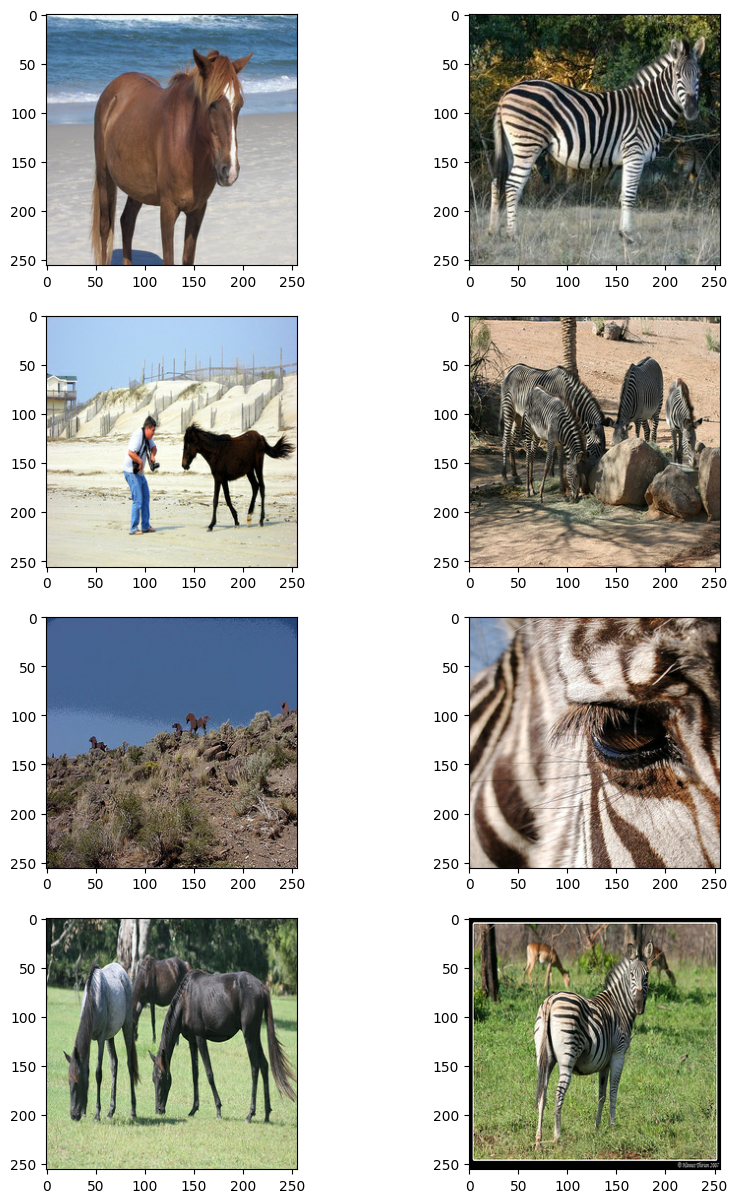

In [5]:
_, ax = plt.subplots(4, 2, figsize=(10, 15))
for i, samples in enumerate(zip(train_horses.take(4), train_zebras.take(4))):
    horse = (((samples[0][0] * 127.5) + 127.5).numpy()).astype(np.uint8)
    zebra = (((samples[1][0] * 127.5) + 127.5).numpy()).astype(np.uint8)
    ax[i, 0].imshow(horse)
    ax[i, 1].imshow(zebra)
plt.show()

In [6]:
class ReflectionPadding2D(layers.Layer):
    """Implements Reflection Padding as a layer.

    Args:
        padding(tuple): Amount of padding for the
        spatial dimensions.

    Returns:
        A padded tensor with the same type as the input tensor.
    """

    def __init__(self, padding=(1, 1), **kwargs):
        self.padding = tuple(padding)
        super(ReflectionPadding2D, self).__init__(**kwargs)

    def call(self, input_tensor, mask=None):
        padding_width, padding_height = self.padding
        # no padding for batch_size and channel axis
        padding_tensor = [
            [0, 0],
            [padding_height, padding_height],
            [padding_width, padding_width],
            [0, 0],
        ]
        return tf.pad(input_tensor, padding_tensor, mode="REFLECT")

In [7]:
def residual_block(
  x,
  activation,
  kernel_initializer=kernel_init,
  kernel_size=(3, 3),
  strides=(1, 1),
  padding="valid",
  gamma_initializer=gamma_init,
  use_bias=False,
):
  dim = x.shape[-1]
  input_tensor = x

  x = ReflectionPadding2D()(input_tensor)
  x = layers.Conv2D(
    dim,
    kernel_size,
    strides=strides,
    kernel_initializer=kernel_initializer,
    padding=padding,
    use_bias=use_bias,
  )(x)
  x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
  x = activation(x)

  x = ReflectionPadding2D()(x)
  x = layers.Conv2D(
    dim,
    kernel_size,
    strides=strides,
    kernel_initializer=kernel_initializer,
    padding=padding,
    use_bias=use_bias,
  )(x)
  x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
  x = layers.add([input_tensor, x])
  return x

In [8]:
def downsample(
    x,
    filters,
    activation,
    kernel_initializer=kernel_init,
    kernel_size=(3, 3),
    strides=(2, 2),
    padding="same",
    gamma_initializer=gamma_init,
    use_bias=False,
):
    x = layers.Conv2D(
        filters,
        kernel_size,
        strides=strides,
        kernel_initializer=kernel_initializer,
        padding=padding,
        use_bias=use_bias,
    )(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    if activation:
        x = activation(x)
    return x

In [9]:
def upsample(
    x,
    filters,
    activation,
    kernel_size=(3, 3),
    strides=(2, 2),
    padding="same",
    kernel_initializer=kernel_init,
    gamma_initializer=gamma_init,
    use_bias=False,
):
    x = layers.Conv2DTranspose(
        filters,
        kernel_size,
        strides=strides,
        padding=padding,
        kernel_initializer=kernel_initializer,
        use_bias=use_bias,
    )(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    if activation:
        x = activation(x)
    return x

In [14]:
def get_resnet_generator(
    filters=64,
    num_downsampling_blocks=2,
    num_residual_blocks=9,
    num_upsample_blocks=2,
    gamma_initializer=gamma_init,
    name=None,
):
    img_input = layers.Input(shape=input_img_size, name= "" if name is None else name + "_img_input")
    x = ReflectionPadding2D(padding=(3, 3))(img_input)
    x = layers.Conv2D(filters, (7, 7), kernel_initializer=kernel_init, use_bias=False)(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    x = layers.Activation("relu")(x)

    # Downsampling
    for _ in range(num_downsampling_blocks):
        filters *= 2
        x = downsample(x, filters=filters, activation=layers.Activation("relu"))

    # Residual blocks
    for _ in range(num_residual_blocks):
        x = residual_block(x, activation=layers.Activation("relu"))

    # Upsampling
    for _ in range(num_upsample_blocks):
        filters //= 2
        x = upsample(x, filters, activation=layers.Activation("relu"))

    # Final block
    x = ReflectionPadding2D(padding=(3, 3))(x)
    x = layers.Conv2D(3, (7, 7), padding="valid")(x)
    x = layers.Activation("tanh")(x)

    model = keras.models.Model(img_input, x, name=name)
    return model

In [18]:
def get_discriminator(
    filters=64, kernel_initializer=kernel_init, num_downsampling=3, name=None
):
    img_input = layers.Input(shape=input_img_size, name= "" if name is None else name + "_img_input")
    x = layers.Conv2D(
        filters,
        (4, 4),
        strides=(2, 2),
        padding="same",
        kernel_initializer=kernel_initializer,
    )(img_input)
    x = layers.LeakyReLU(0.2)(x)

    num_filters = filters
    for num_downsample_block in range(3):
        num_filters *= 2
        if num_downsample_block < 2:
            x = downsample(
                x,
                filters=num_filters,
                activation=layers.LeakyReLU(0.2),
                kernel_size=(4, 4),
                strides=(2, 2),
            )
        else:
            x = downsample(
                x,
                filters=num_filters,
                activation=layers.LeakyReLU(0.2),
                kernel_size=(4, 4),
                strides=(1, 1),
            )

    x = layers.Conv2D(
        1, (4, 4), strides=(1, 1), padding="same", kernel_initializer=kernel_initializer
    )(x)

    model = keras.models.Model(inputs=img_input, outputs=x, name=name)
    return model


# Get the generators
gen_G = get_resnet_generator(name="generator_G")
gen_F = get_resnet_generator(name="generator_F")

# Get the discriminators
disc_X = get_discriminator(name="discriminator_X")
disc_Y = get_discriminator(name="discriminator_Y")